## Регрессия стоимости жилья по районам Бостона

In [2]:
# %load ../imports.py
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib as mpl
import matplotlib.pylab as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

DATASET_PATH = '../../dataset/private/housing.csv'
COLUMN_NAMES = [
    'CR', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
FEATURES = [
    'CR', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT',
]
TARGET = 'MEDV'

Описания столбцов взятые с Kaggle для уточнения:
~~~md
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 
             25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
             river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
             by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's
~~~

In [3]:
data = pd.read_csv(
    DATASET_PATH,
    header=None, 
    names=COLUMN_NAMES, 
    delim_whitespace=True
)
print("Null values:", data.isnull().any(), sep='\n')
data.head()

Null values:
CR         False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
MEDV       False
dtype: bool


,CR,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [42]:
# После небольшого диалога с DeepSeek 
# задача читаемой презентации таблиц корреляций была решена CSS и HTML разметкой

from IPython.display import display, HTML

css = """
<style>
  .flex-row { 
    display: flex;
    flex-wrap: nowrap;
    overflow-x: auto;
  }
  .flex-item {
    min-width: 24%;
  }
</style>
"""
display(HTML(css))

def format_table(table: DataFrame | pd.Series, caption: str = ' '):
  df = table if isinstance(table, DataFrame) else table.to_frame()
  return (df.style
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)
    .format("{:.2f}")
    .set_caption(caption))

def display_grid(elements, row_width):
  size = len(elements)
  for i in range(0, size, row_width):
    row_html = "<div class='flex-row'>"
    for elem in elements[i:i+row_width]:
      row_html += f"<div class='flex-item'>{elem}</div>"
    row_html += "</div>"
    display(HTML(row_html))

Для выбора фич регрессии рассмотрим топ по корреляции и выберем фичи с самыми сильными корреляциями

In [5]:
corr_matrix = data.corr()
target_corr_linear = corr_matrix[TARGET].sort_values(key=abs, ascending=False).drop(TARGET)
format_table(target_corr_linear)

,MEDV
LSTAT,-0.74
RM,0.70
PTRATIO,-0.51
INDUS,-0.48
TAX,-0.47
NOX,-0.43
CR,-0.39
RAD,-0.38
AGE,-0.38
ZN,0.36


Для улучшения качаства регресси необходимо избегать одновременного включения сильно скореллированных фич. Для отбора рассмотрим рейтинги корреляции каждой фичи и отберём исходя из соображений независимости. 

In [ ]:
from IPython.display import display

TOP_SIZE = 12
top_features = target_corr_linear[0:(TOP_SIZE)].keys()

formatted_tables = [
    format_table(
        corr_matrix[feature]
            .drop([feature, TARGET])
            .sort_values(key=abs, ascending=False)
            .to_frame(),
        caption = f"{target_corr_linear[feature]:.2f}"
    ).to_html()  
    for feature in top_features
]

display_grid(formatted_tables, 3)

,LSTAT
RM,-0.61
INDUS,0.60
AGE,0.60
NOX,0.59
TAX,0.54
DIS,-0.50
RAD,0.49
CR,0.46
ZN,-0.41
PTRATIO,0.37


,INDUS
NOX,0.76
TAX,0.72
DIS,-0.71
AGE,0.64
LSTAT,0.60
RAD,0.60
ZN,-0.53
CR,0.41
RM,-0.39
PTRATIO,0.38


,CR
RAD,0.63
TAX,0.58
LSTAT,0.46
NOX,0.42
INDUS,0.41
B,-0.39
DIS,-0.38
AGE,0.35
PTRATIO,0.29
RM,-0.22


,ZN
DIS,0.66
AGE,-0.57
INDUS,-0.53
NOX,-0.52
LSTAT,-0.41
PTRATIO,-0.39
TAX,-0.31
RM,0.31
RAD,-0.31
CR,-0.20


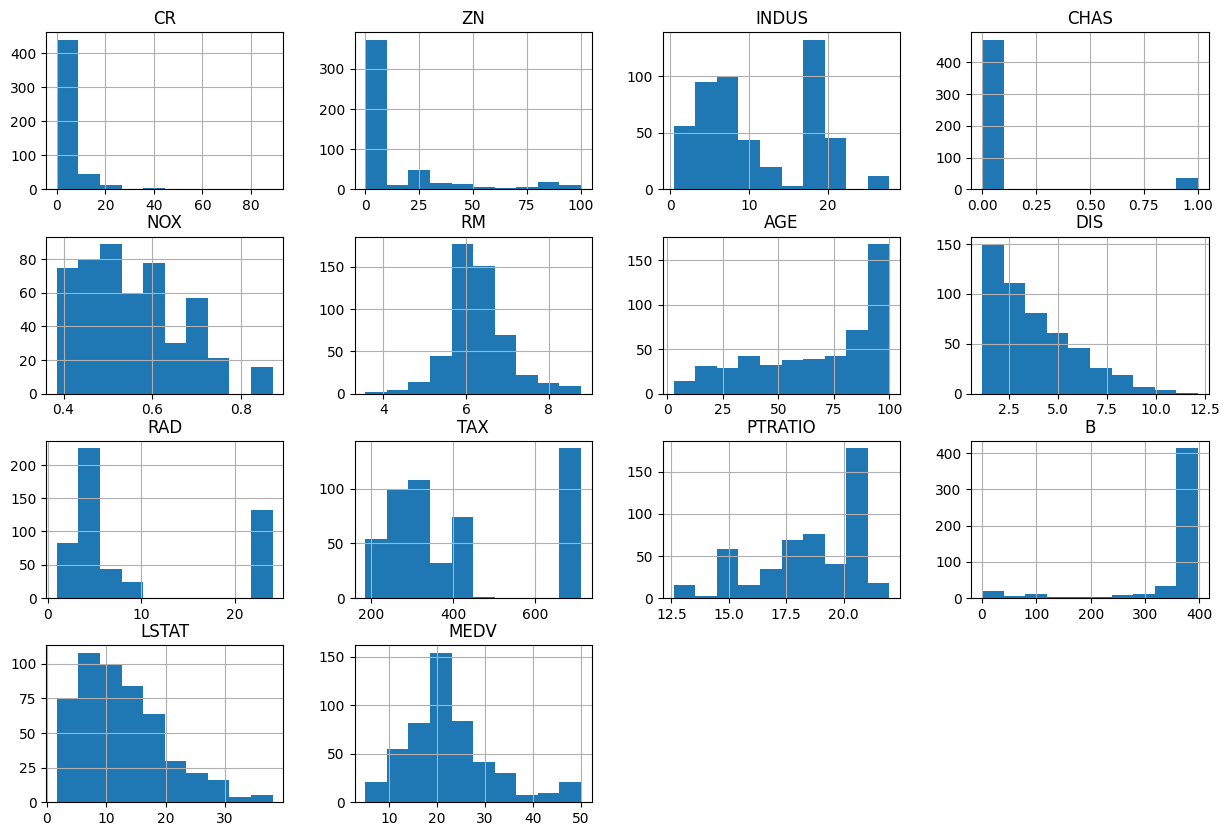

In [7]:
data.hist(figsize=(15, 10)); # Гистограммы

In [8]:
np.sqrt(data.var()) # Посмотрим на ст. отклонения

CR           8.601545
ZN          23.322453
INDUS        6.860353
CHAS         0.253994
NOX          0.115878
RM           0.702617
AGE         28.148861
DIS          2.105710
RAD          8.707259
TAX        168.537116
PTRATIO      2.164946
B           91.294864
LSTAT        7.141062
MEDV         9.197104
dtype: float64

## Вывод
1. Параметры LSTAT и RM сильно скореллированы
    - LSTAT - некий процент жителей низкого достатка(критерий неизвестен)
    - RM - среднее число комнат в жилище
    - RM ближе к нормальному распределению
2. Параметры LSTAT и INDUS сильно скореллированы
    - INDUS - Доля производственного бизнеса(по площади) в районе
- **RM прдпочтительней LSTAT** исходя из трактуемости и остальных корреляций
3. PTRATIO равноотстоит от остальных признаков
    - PTRATIO - отношение числа учеников к числу учителей
    - Также как и INDUS скореллировано с TAX
4. TAX - налоговая ставка
    - вероятно причинна относительно INDUS и PTRATIO
    - Гистограмма INDUS во многом повторяет TAX
5. NOX - концентрация оксида азота в воздухе
    - последствие загрязнения, мерка наличия производства в районе
    -  распределено нормально(?)
    - **хороший кандидат**
6. CR - число преступлений на долю населения
    - заметно скореллирован с RAD, TAX
7. RAD - доступность шоссейных дорог
    - мультииндекс
    - крайне скореллирован с TAX
    - гистограмма повторяет TAX
    - вероятно почти полностью трактуется колиеством налогов уплачиваемых в казну
8. B - доля чёрных в населении района
    - внешний признак, покупатели и риэлторы могут профилировать на его основе
    - напрямую не содержит иной информации о районе

### Итоговый набор кандидатов в сильные предикторы
1. Если искать первопричинные признаки и исключать корреляции
    - RM, PTRATIO, TAX, NOX, CR, AGE, ZN
2. Если считать что покупатели и продавцы смотрят на бытовые данные о районе
    - RM, PTRATIO, INDUS, CR, AGE, ZN, B

In [9]:
# Исследую вариант 1
# ['RM', 'PTRATIO', 'TAX', 'NOX', 'CR', 'AGE', 'ZN'] 
# ['RM', 'PTRATIO', 'INDUS', 'CR', 'AGE', 'ZN', 'B']
PREDICTORS = ['RM', 'PTRATIO', 'TAX', 'NOX', 'CR', 'AGE', 'ZN'] 
FEATURE_COUNTS = [2, 4, 7, 13]

X, y = data[FEATURES], data[TARGET]

In [10]:
from sklearn.linear_model import LinearRegression

# Автоматизируем обучение постепенно увеличивая число фич 
def train_model_suite(X: DataFrame, y: pd.Series, predictors=None, feature_counts=None) -> dict[int, LinearRegression]:
    if predictors is None:
        predictors = X.keys()
    if feature_counts is None:
        feature_counts = [len(predictors)]
    
    models = {c: None for c in feature_counts}

    for k_features in feature_counts:
        X_cut = X[predictors[:k_features]]
        model = LinearRegression()
        model.fit(X_cut, y)
        models[k_features] = model
    return models

In [11]:
import sklearn.metrics as sklm

def scoring_procedure(y_true, y_pred, header=''):
    abs_err = abs(y_true - y_pred)
    mse = sklm.mean_squared_error(y_true, y_pred)
    report = f"""
    {header}
    MSE: {mse:.3f}
    RMSE: {np.sqrt(mse):.3f} 
    R2: {sklm.r2_score(y_true, y_pred):.3f}
    MAPE: {sklm.mean_absolute_percentage_error(y_true, y_pred):.3f}
    """
    print(report)

Натренируем наборы моделей с разным числом как столбцов так и строк

In [33]:
from sklearn.model_selection import train_test_split
from random import randint

# Стандартизируем тесты использовав тест 20%
random_state = randint(1, 100) 
X_train_80_20, X_test_80_20, y_train_80_20, y_test_80_20 = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train_50_50, _, y_train_50_50, _ = train_test_split(X, y, test_size=0.5, random_state=random_state)
X_train_20_80, _, y_train_20_80, _ = train_test_split(X, y, test_size=0.8, random_state=random_state)

In [34]:
models_80_20 = train_model_suite(X_train_80_20, y_train_80_20, PREDICTORS, FEATURE_COUNTS)
models_50_50 = train_model_suite(X_train_50_50, y_train_50_50, PREDICTORS, FEATURE_COUNTS)
models_20_80 = train_model_suite(X_train_20_80, y_train_20_80, PREDICTORS, FEATURE_COUNTS)

In [35]:
print("80% data rows")
for k_features in models_80_20.keys():
    model = models_80_20[k_features]
    index = PREDICTORS[:k_features]
    prediction = model.predict(X_test_80_20[index])
    scoring_procedure(y_test_80_20, prediction, header=f"{k_features} feature model")

80% data rows

    2 feature model
    MSE: 22.426
    RMSE: 4.736 
    R2: 0.662
    MAPE: 0.187
    

    4 feature model
    MSE: 17.540
    RMSE: 4.188 
    R2: 0.735
    MAPE: 0.159
    

    7 feature model
    MSE: 17.714
    RMSE: 4.209 
    R2: 0.733
    MAPE: 0.159
    

    13 feature model
    MSE: 17.714
    RMSE: 4.209 
    R2: 0.733
    MAPE: 0.159
    


In [36]:
print("50% data rows")
for k_features in models_50_50.keys():
    model = models_50_50[k_features]
    index = PREDICTORS[:k_features]
    prediction = model.predict(X_test_80_20[index])
    scoring_procedure(y_test_80_20, prediction, header=f"{k_features} feature model")

50% data rows

    2 feature model
    MSE: 22.105
    RMSE: 4.702 
    R2: 0.666
    MAPE: 0.189
    

    4 feature model
    MSE: 17.790
    RMSE: 4.218 
    R2: 0.731
    MAPE: 0.166
    

    7 feature model
    MSE: 17.931
    RMSE: 4.235 
    R2: 0.729
    MAPE: 0.165
    

    13 feature model
    MSE: 17.931
    RMSE: 4.235 
    R2: 0.729
    MAPE: 0.165
    


In [37]:
print("20% data rows")
for k_features in models_20_80.keys():
    model = models_20_80[k_features]
    index = PREDICTORS[:k_features]
    prediction = model.predict(X_test_80_20[index])
    scoring_procedure(y_test_80_20, prediction, header=f"{k_features} feature model")

20% data rows

    2 feature model
    MSE: 27.052
    RMSE: 5.201 
    R2: 0.592
    MAPE: 0.196
    

    4 feature model
    MSE: 22.936
    RMSE: 4.789 
    R2: 0.654
    MAPE: 0.184
    

    7 feature model
    MSE: 23.352
    RMSE: 4.832 
    R2: 0.648
    MAPE: 0.184
    

    13 feature model
    MSE: 23.352
    RMSE: 4.832 
    R2: 0.648
    MAPE: 0.184
    


## Вывод

Добавление новых признаков(фич) на любом числе данных улучшает модель, но изменения малозаметны даже при кратном увеличении числа признаков. Вероятно коллинеарность в наборе признаков является причиной замедления роста качества модели и может являтся фактором в переобучении модели.  

Увеличение числа данных однозначно позитивно влияет на рост качества модели.  

Не был зафиксирован, но был проведён эксперимент с другим набором признаков и качество моделей упало, из чего следует что проведённый анализ признаков можно считать относительно успешным. 

Лучшими кандидатами я бы назвал модели 80% с 4-7 признаками. 

Изобразим плоскость регресси для модели из двух параметров

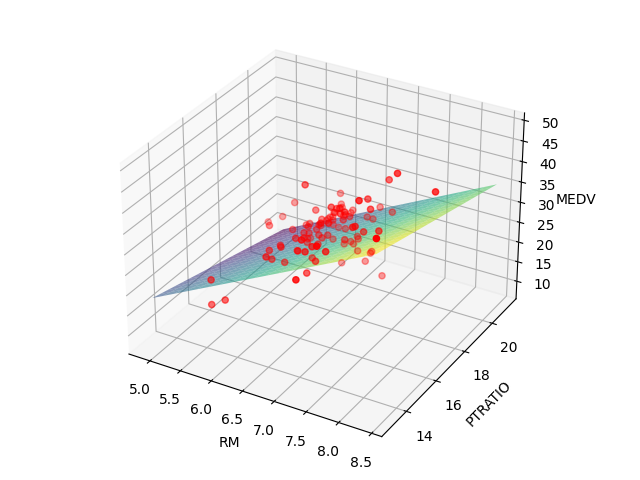

In [38]:
%matplotlib widget

feature1, feature2 = PREDICTORS[:2]

x1 = np.linspace(X_test_80_20[feature1].min(), X_test_80_20[feature1].max(), 20)
x2 = np.linspace(X_test_80_20[feature2].min(), X_test_80_20[feature2].max(), 20)
x1_grid, x2_grid = np.meshgrid(x1, x2)

grid_points = np.c_[x1_grid.ravel(), x2_grid.ravel()]
z = models_80_20[2].predict(grid_points).reshape(x1_grid.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    x1_grid, 
    x2_grid, 
    z, 
    alpha=0.6,
    cmap='viridis'
)
ax.scatter(
    X_test_80_20[feature1], 
    X_test_80_20[feature2], 
    y_test_80_20, 
    c='red'
)

ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_zlabel(TARGET)

plt.tight_layout()
plt.show()

Другим подходом к выделению признаков и построению регресси может являться выделение новых признаков на основе метода главных компонент(PCA). В завершение спроецируем признаки на главные компоненты, попробуем трактовать сами компоненты и для сравнения натренируем модель. 

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_80_20)
X_test_scaled = scaler.transform(X_test_80_20)

total_decomposition = PCA(n_components=X_train_scaled.shape[1]).fit(X_train_scaled)
print(*total_decomposition.explained_variance_ratio_.cumsum(), sep='\n')

0.4733580396231979
0.5859462689665315
0.6792953563058727
0.7451791589559954
0.8068111261950981
0.8583774247009568
0.9004499163351216
0.9310531183407142
0.9508485482115006
0.9676422995586587
0.9822084779713652
0.9952520036592659
1.0000000000000002


In [48]:
pca = PCA(n_components=5).fit(X_train_scaled)

components = DataFrame(
    pca.components_.T,
    index=X.columns
)

formatted_components = [
    format_table(components[k_component].sort_values(key=abs, ascending=False)).to_html()
    for k_component in components.columns
]

display_grid(formatted_components, 3)

,0
INDUS,0.35
NOX,0.34
TAX,0.34
DIS,-0.32
RAD,0.32
AGE,0.31
LSTAT,0.31
ZN,-0.26
CR,0.25
PTRATIO,0.21


,3
PTRATIO,-0.67
B,-0.40
LSTAT,0.30
ZN,0.26
CHAS,-0.23
RM,-0.23
RAD,-0.22
NOX,0.20
TAX,-0.14
AGE,0.08


Главные компоненты можно охарактреизовать как:
  
0. Фактор производственного бизнеса и налоговой нагрузки
1. Престиж и инфраструктура района
2. Размер жилья и демографический профиль 

In [41]:
X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

model_PCA = LinearRegression().fit(X_train_PCA, y_train_80_20)
prediction_PCA = model_PCA.predict(X_test_PCA)
scoring_procedure(y_test_80_20, prediction_PCA, header='PCA-backed model')


    PCA-backed model
    MSE: 15.096
    RMSE: 3.885 
    R2: 0.772
    MAPE: 0.155
    


Несмотря на небольшое число признаков PCA модель показала хороший результат. Удалось избежать нетривиального анализа данных, в добавок, мы произвели уменьшение размерности. Вероятно стоит отметить, что от эксперимента к эксперименту R2 показатели меняются значительно и находились исходы, где предварительная подготовка пространства признаков не показывала значительных преимуществ и даже проигрывала. 